# Introduction to Statistical Learning

*March 26, 2024*

---

## Types of Statistical Learning Problems

Whether we're interested in prediction or inference, there are a few different ways to describe statistical learning problems that are worth discussing.

**First, we can describe a problem as either one of *classification* or of *regression*.**

![](classification_v_regression.jpg)

*Image from r-craft.org*

---

## Introduction to `scikit-learn`

[The `scikit-learn` website showcases these broad problem categories](https://scikit-learn.org/stable/), including classification and regression. 

In [1]:
import rasterio as rio
import numpy as np

# RGB data
neon = rio.open('http://files.ntsg.umt.edu/data/GIS_Programming/data/NEON_ortho.tif')
rgb = np.rollaxis(neon.read([1,2,3]), 0, 3)

# Hyperspectral data
neon2 = rio.open('http://files.ntsg.umt.edu/data/GIS_Programming/data/NEON_hyperspectral.tif')
neon2.count

86

In [2]:
bands = list(range(1, 87))

In [3]:
hyper = neon2.read(bands) / 10e3 # This converts to reflectance units for this specific dataset
hyper.shape

(86, 1000, 1000)

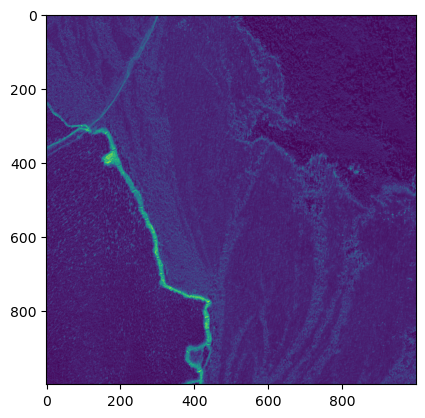

In [6]:
import matplotlib.pyplot as plt

plt.imshow(hyper[12])

![](supervised_v_unsupervised.jpg)

*Image from r-craft.org*

Running a model in `scikit-learn` generally consists of the following steps:

1. Initializing the model with certain fixed parameters.
2. Fitting the model to **training data** so that it can learn the relationships you're interested in.
3. Examining the nature of those relationships *or* applying the model to **predict** new cases in **test data.**


### Preparing Our Data

Our training data need to have a specific form:

$$
\text{Training Data} = \left[\begin{array}{ccc}
x_{ij} & \cdots\\
\vdots & \\
\end{array}\right]
$$

In [7]:
hyper.shape

(86, 1000, 1000)

In [8]:
hyper2 = np.rollaxis(hyper, 0, 3)
hyper2.shape

(1000, 1000, 86)

In [9]:
# I want to collapse the first two axes to create a flat array where 
# rows are pixels and columns are features (bands)
# THIS IS MOVING FROM GEOGRAPHIC SPACE TO FEATURE SPACE
cases = hyper2.reshape((1000*1000, 86))
cases.shape

(1000000, 86)

In [10]:
# Let's train our model on 20,000 pixels
# np.random.seed(42)

random = np.arange(0, cases.shape[0])

np.random.shuffle(random)
random

array([403596, 914880,  81482, ..., 245638, 466946, 664510])

In [12]:
# We can use this argument to test for membership between 1st and 2nd arrays
np.in1d([0, 1, 2, 3], [2, 3])

array([False, False,  True,  True])

In [15]:
# Is this numeric index one of the ones we randomly chose?
mask = np.in1d(np.arange(0, cases.shape[0]), random[0:20000])
# The above will create a 1D boolean (True/False) array of 1,000,000 pixels where 20,000 are True
print(mask.shape)
print(sum(mask))

(1000000,)
20000


### Unspervised Learning with $k$-Means Clustering

The simplest example of unsupervised clustering is that of $k$-means clustering. 

![](kmeans.gif)

*Image from Syed Sadat Nazrul*

In [16]:
from sklearn.cluster import KMeans

                # Find 3 clusters, and start with 10 randomly chosen group means
kmeans = KMeans(n_clusters = 3, n_init = 10)

# Now we have a model that's ready to be trained
# Fit model to training data
kmeans.fit(cases[mask])

# Generate predictions
labels = kmeans.predict(cases)
labels.shape # We can confirm that there are the same number of pixels as predictions

(1000000,)

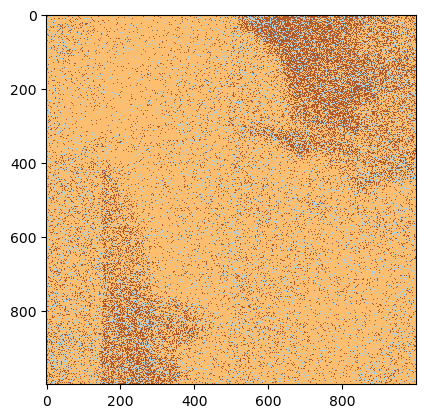

In [17]:
# Now the challenge is to move back from prediction space to geogrphic space
plt.imshow(labels.reshape((1000, 1000)), cmap = 'Paired', interpolation = 'nearest')

In [19]:
waves = np.arange(381, 2510, 25) # Steps of 25nm between bands
# The resulting array is the actual wavelengths of our 86 bands
waves

array([ 381,  406,  431,  456,  481,  506,  531,  556,  581,  606,  631,
        656,  681,  706,  731,  756,  781,  806,  831,  856,  881,  906,
        931,  956,  981, 1006, 1031, 1056, 1081, 1106, 1131, 1156, 1181,
       1206, 1231, 1256, 1281, 1306, 1331, 1356, 1381, 1406, 1431, 1456,
       1481, 1506, 1531, 1556, 1581, 1606, 1631, 1656, 1681, 1706, 1731,
       1756, 1781, 1806, 1831, 1856, 1881, 1906, 1931, 1956, 1981, 2006,
       2031, 2056, 2081, 2106, 2131, 2156, 2181, 2206, 2231, 2256, 2281,
       2306, 2331, 2356, 2381, 2406, 2431, 2456, 2481, 2506])

In [21]:
np.argwhere(np.logical_and(waves > 625, waves < 1400)).ravel()
# This selects bands where wavelength is between 625 adn 1400nm

array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40],
      dtype=int64)

In [22]:
cases[mask, 10:40].shape

(20000, 30)

In [23]:
kmeans.fit(cases[mask, 10:40])

KMeans(n_clusters=3, n_init=10)

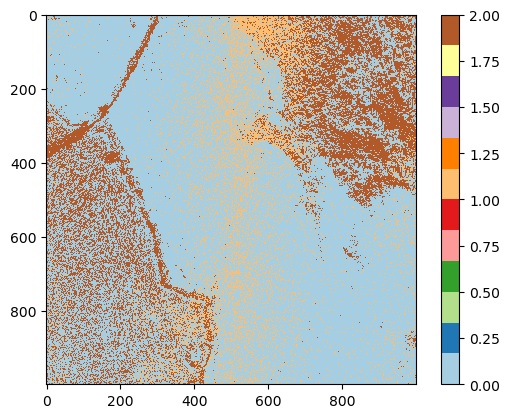

In [25]:
labels = kmeans.predict(cases[:, 10:40])
plt.imshow(labels.reshape((1000,1000)), cmap = 'Paired', interpolation = 'nearest')
plt.colorbar()

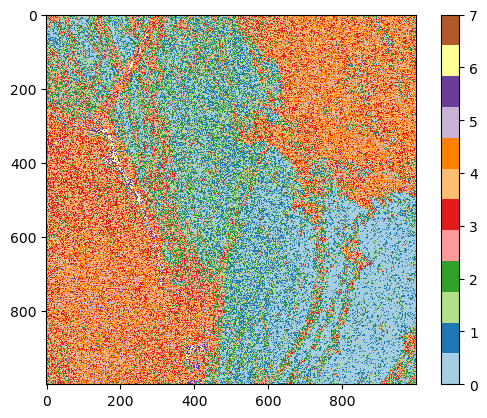

In [26]:
kmeans = KMeans(n_clusters = 8, n_init = 10)
kmeans.fit(cases[mask,10:40])
labels = kmeans.predict(cases[:,10:40])
plt.imshow(labels.reshape((1000, 1000)), cmap = 'Paired')
plt.colorbar()

### Supervised Classification with $k$-Nearest Neighbors

In [27]:
# NOTE: we're talking about the feature space with 'nearest', not geographic space
# We're going to manually label pixels.
# Let's start with an empty labels array
labels = np.zeros(rgb.shape[0:2])
labels.shape

(1000, 1000)

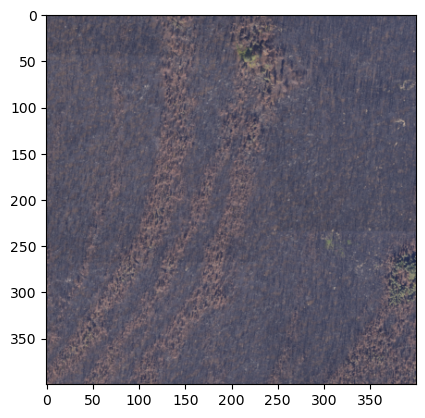

In [28]:
plt.imshow(rgb[600:, 600:,])

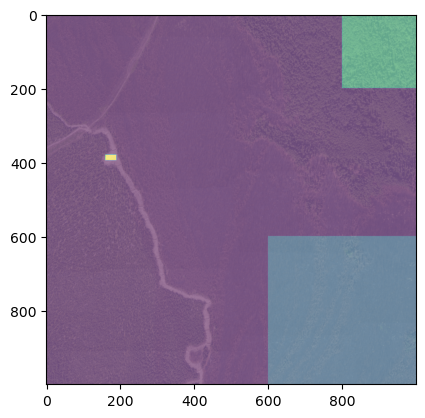

In [32]:
# We're going to call the above image our supervised 'burned area'
# Let's also label other areas
labels[600:, 600:] = 1 # 1 = Burned; the bottom-right corner
labels[0:200, 800:] = 2 # 2 = Unburned; the top-right corner
labels[380:395, 160:190] = 3 # 3 = Road, the bright parking lot near top-left corner

plt.imshow(rgb, alpha = 0.5)
plt.imshow(labels, alpha = 0.5)

In [33]:
hyper2.shape

(1000, 1000, 86)

In [34]:
hyper2[labels == 1].shape

(160000, 86)

In [35]:
400*400

160000

In [36]:
# Get all pixels that have a label
X = hyper2[labels > 0]
X.shape

(200450, 86)

In [37]:
Y = labels[labels > 0]
Y.shape

(200450,)

We're ready to train our model. This next code block will take about 30-60 seconds to run.

In [38]:
from sklearn.neighbors import KNeighborsClassifier

# Can re-try with larger number of spectral bands
bands = np.array([10, 11, 12, 13, 14, 33, 34, 36, 37])

# But let's just use 2 to start
bands = np.array([12, 34])

knn = KNeighborsClassifier(n_jobs = 4)
knn.fit(X[:,bands], Y)
predicted_labels = knn.predict(cases[:,bands])

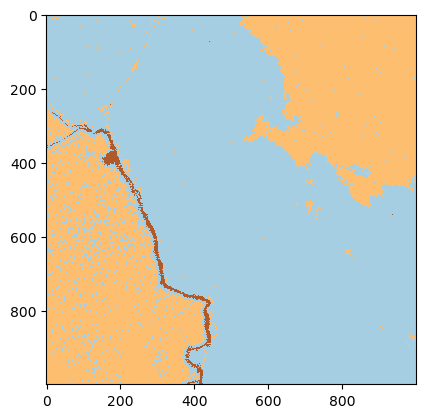

In [39]:
# Convert back to geographic space
predictions = predicted_labels.reshape((1000,1000))
plt.imshow(predictions, cmap = 'Paired', interpolation = 'nearest')

## Evaluating the Performance of a Classifier

In [41]:
# Confusion matrix is used to evaluate performance of the classifier
# If our model classified all 3 categories 100% correctly, there would only be numbers in the diagonal
from sklearn.metrics import confusion_matrix

confusion_matrix(Y, predictions[labels > 0])

array([[159415,    584,      1],
       [   262,  39738,      0],
       [     6,      0,    444]], dtype=int64)

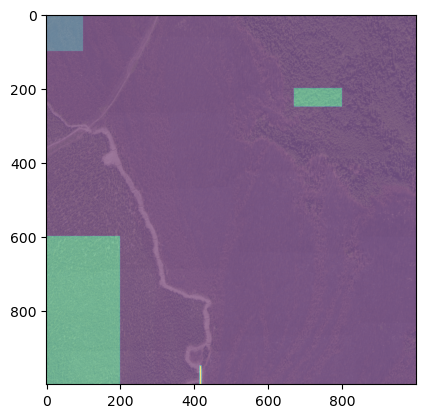

In [42]:
labels2 = np.zeros(rgb.shape[0:2])

labels2[0:100, 0:100] = 1
labels2[600:, 0:200] = 2
labels2[200:250, 670:800] = 2
labels2[950:,415:420] = 3

plt.imshow(rgb, alpha = 0.5)
plt.imshow(labels2, alpha = 0.5)
plt.show()

In [44]:
# This confusion matrix lists in percentages, which is a more interpretable indicator
confusion_matrix(labels2[labels2 > 0], predictions[labels2 > 0], 
    normalize = 'true').round(3) * 100

array([[98.5,  1.5,  0. ],
       [ 9.5, 90.5,  0. ],
       [18.8,  0. , 81.2]])